# Homework 2. Latent Variable Models

- Part 1 (5 points): VAEs on 2D Data
- Part 2 (20 points): VAEs on images
    - VAE
    - VAE with AF Prior
- \*Bonus

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import OrderedDict, defaultdict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Useful functions

In [3]:
def train_epoch(model, train_loader, optimizer, epoch, grad_clip=None):
    """
    train model on loader for single epoch
    returns Dict[str, List[float]] - dict of losses on each training batch
    """
    losses = defaultdict(list)

    for e in range(epoch):

        model.train()
        
        for inputs in train_loader:

            optimizer.zero_grad()

            inputs = inputs.to(device)
            train_loss = model.loss(inputs)

            train_loss["loss"].backward()
            optimizer.step()
            
            for k, v in train_loss.items():
                losses[k].append(v.item())

    return losses


def valid_epoch(model, data_loader):
    """
    evaluates model on dataset
    returns Dict[str, float] - dict with average losses on entire dataset
    """
    model.eval()
    average_losses = defaultdict(float)

    with torch.no_grad():

        for inputs in data_loader:

            inputs = inputs.to(device)
            test_loss = model.loss(inputs)

            for k, v in test_loss.items():
                average_losses[k] += v.item() * inputs.size(0)

        for k in average_losses.keys():
            average_losses[k] /= len(data_loader.dataset)

    return average_losses


def train_loop(model, train_loader, test_loader, epochs=10, lr=1e-2, grad_clip=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = defaultdict(list), defaultdict(list)
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, train_loader, optimizer, epoch, grad_clip)
        test_loss = valid_epoch(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [4]:
def plot_vae_training_plot(train_losses, test_losses, title):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Part 1: VAEs on 2D Data (5 points)
Here we will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Data
We will use 4 datasets, each sampled from some gaussian.

In [5]:
def sample_data_1_a(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_2_a(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + (rand.randn(count, 2) * [[1.0, 5.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_1_b(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2_b(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + rand.randn(count, 2) * [[1.0, 5.0]]


def q1_sample_data(part, dset_id):
    assert dset_id in [1, 2]
    assert part in ['a', 'b']
    if part == 'a':
        if dset_id == 1:
            dset_fn = sample_data_1_a
        else:
            dset_fn = sample_data_2_a
    else:
        if dset_id == 1:
            dset_fn = sample_data_1_b
        else:
            dset_fn = sample_data_2_b

    train_data, test_data = dset_fn(10000), dset_fn(2500)
    return train_data.astype('float32'), test_data.astype('float32')


def visualize_q1_data(part, dset_id):
    train_data, test_data = q1_sample_data(part, dset_id)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1])
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1])
    print(f'Dataset {dset_id}{part}')
    plt.show()

Dataset 1a


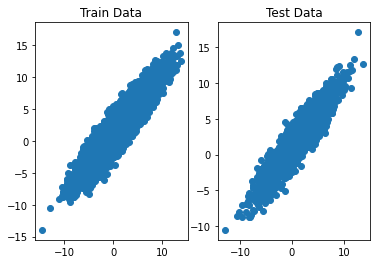

Dataset 2a


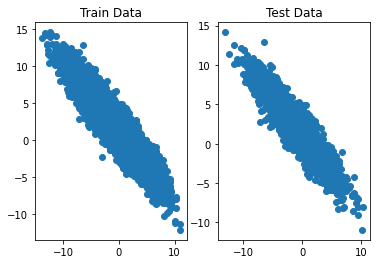

Dataset 1b


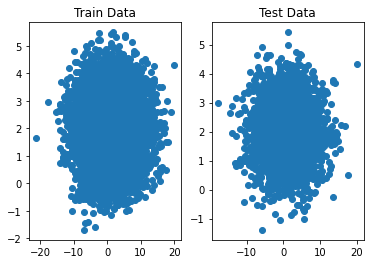

Dataset 2b


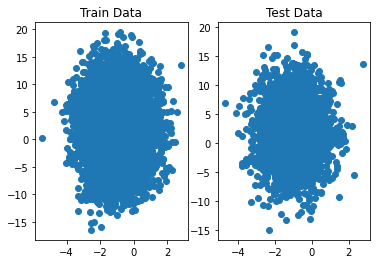

In [6]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

Construct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




## Solution
Fill out the functions below, create additional classes/functions/cells if needed

In [7]:
from typing import MutableMapping
class VAEModel(nn.Module):
    def loss(self, x):
        """
        returns dict with losses (loss_name -> loss_value)
        """
        return {"loss": 0.0, "reconstruction_loss": 0.0, "kl_loss": 0.0}

    def sample(self, n, noise=True):
        """
        returns numpy array of n sampled points, shape=(n, 2)
        """
        return np.zeros((n, 2))


class FullyConnectedVAE(VAEModel):
    # YOUR CODE HERE (define encoder & decoder in __init__)
    def __init__(self, input_size, latent_size, hidden_size=16):
        super(FullyConnectedVAE, self).__init__()
        self.latent_size = latent_size
        self.encoder_mean = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
        )
        self.encoder_std = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
        )
        self.decoder_mean = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )
        self.decoder_std = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def loss(self, x):
        mu_z, log_std_z = self.encoder_mean(x), self.encoder_std(x)
        z = mu_z + torch.randn(mu_z.shape).to(device) * torch.exp(log_std_z)
        mu_x, log_std_x = self.decoder_mean(z), self.decoder_std(z)

        # Compute reconstruction loss
        dist = torch.distributions.Normal(mu_x, torch.exp(log_std_x))
        recon_loss = - torch.mean(dist.log_prob(x))

        # Compute KL
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_std_z - mu_z ** 2 - log_std_z.exp(), dim = 1), dim = 0)

        loss = recon_loss + kl_loss
        return {"loss": loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    def sample(self, n, noise=True):
        # YOUR CODE
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).to(device)
            mu_x = self.decoder_mean(z)
            if not noise:
                x = mu_x
            else:
                log_std_x = self.decoder_std(z)
                x = mu_x + torch.randn(mu_x.shape).to(device) * torch.exp(log_std_x)
            return x.detach().cpu().numpy()

In [8]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    model = FullyConnectedVAE(2, 2).to(device)
    train_loader = data.DataLoader(torch.from_numpy(train_data).to(device), batch_size=128, shuffle=True)
    test_loader = data.DataLoader(torch.from_numpy(test_data).to(device), batch_size=128)
    train_losses, test_losses = train_loop(model, train_loader, test_loader, epochs=10, lr=1e-3)
    train_losses = np.stack((train_losses['loss'], train_losses['reconstruction_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['reconstruction_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

## Results

Dataset 1a


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Final -ELBO: 2.2166, Recon Loss: 1.3966, KL Loss: 0.8200


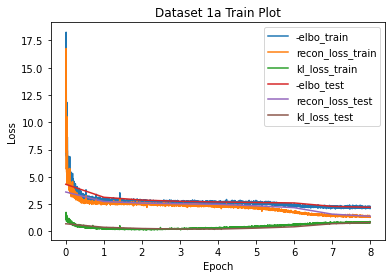

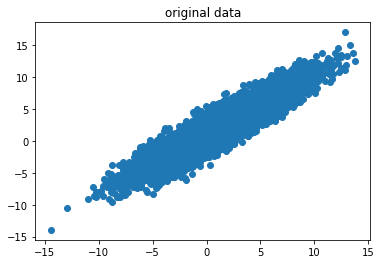

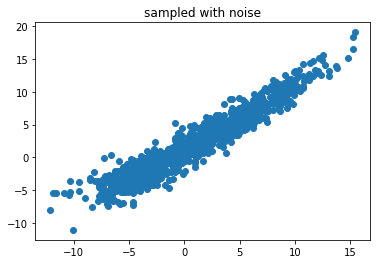

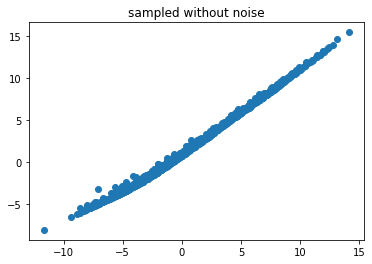

Dataset 2a


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Final -ELBO: 2.6045, Recon Loss: 2.3913, KL Loss: 0.2133


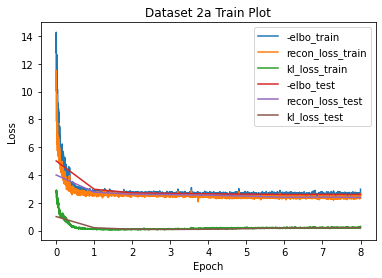

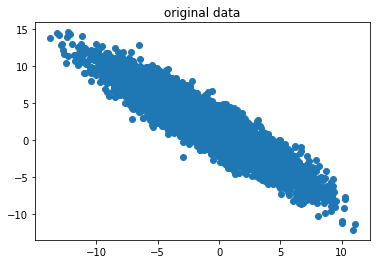

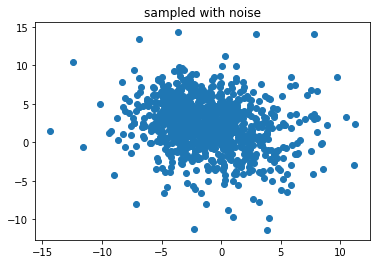

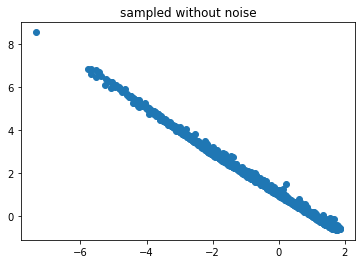

Dataset 1b


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Final -ELBO: 2.1991, Recon Loss: 2.1693, KL Loss: 0.0298


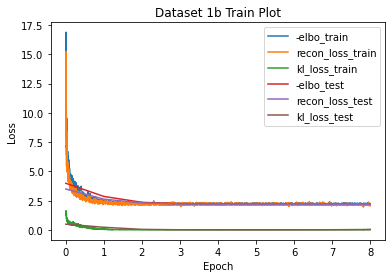

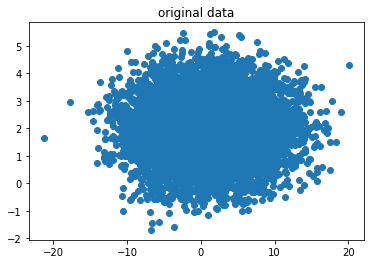

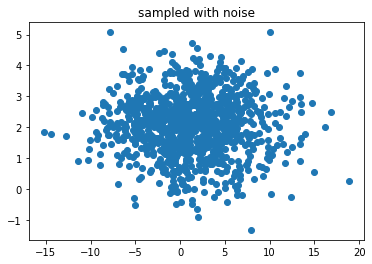

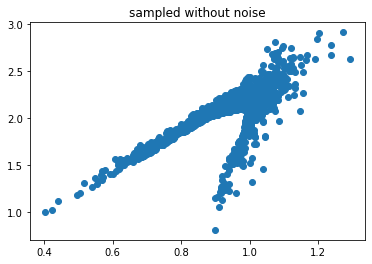

Dataset 2b


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Final -ELBO: 2.1889, Recon Loss: 2.1341, KL Loss: 0.0547


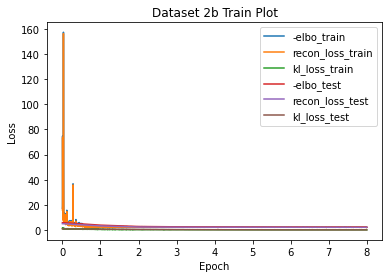

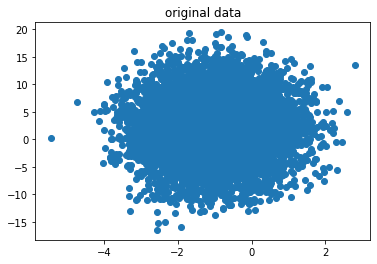

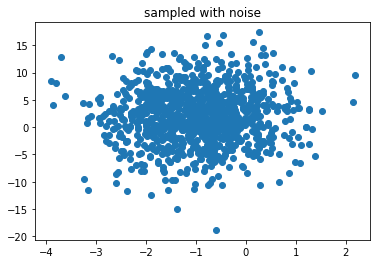

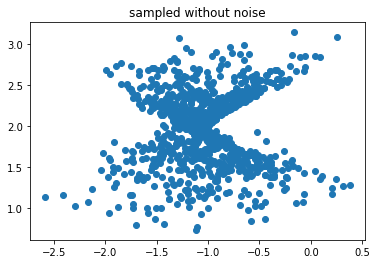

In [10]:
def draw_2d(samples, title):
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()

def q1_results(part, dset_id, fn):
    print(f"Dataset {dset_id}{part}")
    train_data, test_data = q1_sample_data(part, dset_id)
    train_losses, test_losses, samples_noise, samples_nonoise = fn(train_data, test_data, part, dset_id)
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, title=f'Dataset {dset_id}{part} Train Plot')
    draw_2d(train_data, 'original data')
    draw_2d(samples_noise, 'sampled with noise')
    draw_2d(samples_nonoise, 'sampled without noise')
    
q1_results('a', 1, q1)
q1_results('a', 2, q1)
q1_results('b', 1, q1)
q1_results('b', 2, q1)

## Reflection
Compare the sampled xs with and without decoder noise for datasets (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? 

**Write your answer (1-2 sentences):**
Не до конца поняла вопрос, но когда у нас идет акцент на KL loss, то мы плохо описываем данные нашим латентным представлением, что можно видеть на Dataset 1b, 2b. Если акцент на reconstruction loss, то сеть начинает халявить и выучивает узкое представление с маленьким variance, что можно видеть на датасетах 1a, 2a.

# Part 2: VAEs on Images

After the previous exercise you should understand how to train simple VAE. Now let's move from 2D space to more complex image spaces. The training methodology is just the same, the only difference is if we want to have good results we should have better encoder and decoder models.

In this section, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (CIFAR10, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

Files already downloaded and verified


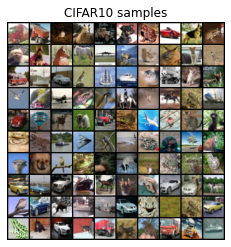

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat
(26032, 32, 32, 3)


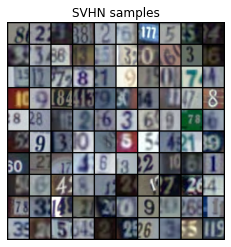

In [11]:
from torchvision.datasets import SVHN, CIFAR10
from torchvision.utils import make_grid

def show_samples(samples, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


DATA_DIR = './data'
def get_cifar10():
    train = CIFAR10(root=f'{DATA_DIR}/cifar10', train=True, download=True).data
    test = CIFAR10(root=f'{DATA_DIR}/cifar10', train=False).data
    return train, test


def get_svhn():
    train = SVHN(root=f'{DATA_DIR}/svhn', split='train', download=True).data.transpose(0, 2, 3, 1)
    test = SVHN(root=f'{DATA_DIR}/svhn', split='test', download=True).data.transpose(0, 2, 3, 1)
    return train, test


def visualize_cifar10():
    _, test = get_cifar10()
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="CIFAR10 samples")


def visualize_svhn():
    _, test = get_svhn()
    print(test.shape)
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="SVHN samples")

visualize_cifar10()
visualize_svhn()

## Part (a) VAE (10 points)
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



In [12]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        shape = (x.size(0), ) + self.shape
        return x.view(shape)

class ImageVAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(ImageVAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 256, 2 * latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 128),
            nn.ReLU(),
            Reshape(128, 4, 4),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
        )

    def loss(self, x):
        mu_z, log_std_z = torch.chunk(self.encoder(x), 2, dim=1)
        z = mu_z + torch.randn(mu_z.shape).to(device) * torch.exp(log_std_z)
        x_hat = self.decoder(z)

        # Compute reconstruction loss
        x_dist = torch.distributions.Normal(x_hat, torch.ones_like(x_hat))
        log_pxz = x_dist.log_prob(x)
        recon_loss = - torch.mean(torch.sum(log_pxz, dim = (1, 2, 3)))

        # Compute KL 
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_std_z - mu_z ** 2 - log_std_z.exp(), dim = 1))

        loss = recon_loss + kl_loss
        return {"loss": loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    def sample(self, n, x=None):
        with torch.no_grad():
            if x is not None:
                mu_z, log_std_z = torch.chunk(self.encoder(x), 2, dim=1)
                z = mu_z + torch.randn(n, self.latent_size).to(device) * torch.exp(log_std_z)
            else:
                z = torch.randn(n, self.latent_size).to(device)
            x_hat = self.decoder(z).clamp(0, 1)
            return x_hat.permute(0, 2, 3, 1).cpu().detach().numpy()

    def interpolate(self, x1, x2):
        with torch.no_grad():
            x_hats = []
            lambda_range = np.linspace(0, 1, 10)
            for i in range(len(x1)):
                img1 = x1[i]
                img2 = x2[i]
                mu_1, _ = torch.chunk(self.encoder(img1.unsqueeze(0)), 2, dim=1)
                mu_2, _ = torch.chunk(self.encoder(img2.unsqueeze(0)), 2, dim=1)
                for lam in lambda_range:
                    x_hats.append(self.decoder(lam * mu_1 + (1 - lam) * mu_2).clamp(0, 1).squeeze(0).cpu().detach().numpy())
        return np.transpose(np.array(x_hats), (0, 2, 3, 1))

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [15]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    model = ImageVAE((32, 32, 3), 16).to(device)

    train_data = (np.transpose(train_data / 255., (0, 3, 1, 2))).astype('float32')
    test_data = (np.transpose(test_data / 255., (0, 3, 1, 2))).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_loop(model, train_loader, test_loader, epochs=5, lr=1e-3)
    train_losses = np.stack((train_losses['loss'], train_losses['reconstruction_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['reconstruction_loss'], test_losses['kl_loss']), axis=1)

    samples = model.sample(100)

    idx_50 = np.random.randint(len(test_data), size=50)
    test_50 = test_data[idx_50]
    recon_50 = model.sample(50, torch.from_numpy(test_50).to(device))

    idx_20 = np.random.randint(len(test_data), size=20)
    x1 = torch.from_numpy(test_data[idx_20][:10]).to(device)
    x2 = torch.from_numpy(test_data[idx_20][10:]).to(device)
    interpolate = model.interpolate(x1, x2)

    return train_losses, test_losses, samples * 255, np.vstack((np.transpose(test_50, (0, 2, 3, 1)) * 255, recon_50 * 255)), interpolate * 255

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Files already downloaded and verified


100%|██████████| 5/5 [01:26<00:00, 17.33s/it]


Final -ELBO: 2862.4439, Recon Loss: 2852.9316, KL Loss: 9.5123


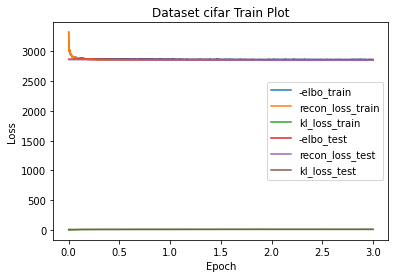

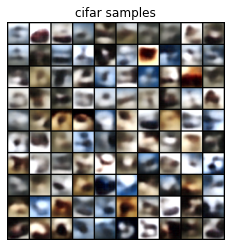

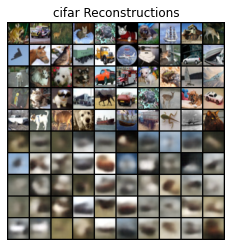

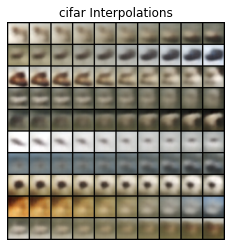

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


100%|██████████| 5/5 [02:13<00:00, 26.73s/it]


Final -ELBO: 2842.1101, Recon Loss: 2836.2436, KL Loss: 5.8665


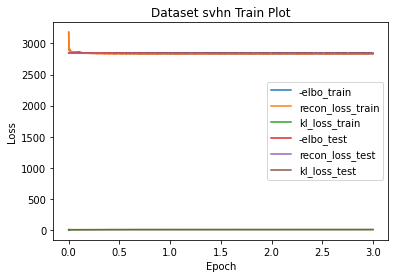

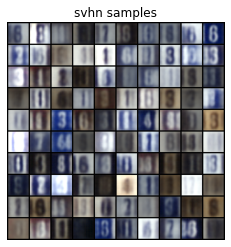

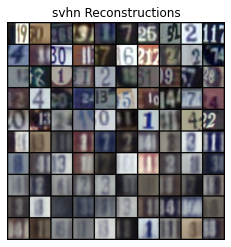

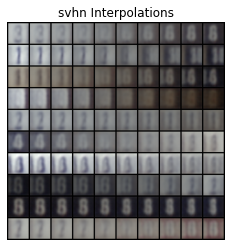

In [16]:
def q2_results(dset_id, fn):
    if dset_id.lower() == 'cifar':
        train_data, test_data = get_cifar10()
    elif dset_id.lower() == 'svhn':
        train_data, test_data = get_svhn()
    else:
        raise ValueError("Unsupported dataset")

    train_losses, test_losses, samples, reconstructions, interpolations = fn(train_data, test_data, dset_id)
    samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, f'Dataset {dset_id} Train Plot')
    show_samples(samples, title=f'{dset_id} samples')
    show_samples(reconstructions, title=f'{dset_id} Reconstructions')
    show_samples(interpolations, title=f'{dset_id} Interpolations')

q2_results('cifar', q2_a)
q2_results('svhn', q2_a)

## Part (b) VAE with AF Prior (10 points)
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [17]:
# Andrew Karpathy Implementation of MADE

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [18]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        shape = (x.size(0), ) + self.shape
        return x.view(shape)

class ImageVLAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(ImageVLAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 256, 2 * latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 128),
            nn.ReLU(),
            Reshape(128, 4, 4),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
        )
        self.made = MADE(latent_size, [512, 512], 2 * latent_size)

    def loss(self, x):
        mu_z, log_std_z = torch.chunk(self.encoder(x), 2, dim=1)
        z = mu_z + torch.randn(mu_z.shape).to(device) * torch.exp(log_std_z)
        x_hat = self.decoder(z)
        
        # Compute reconstruction loss: p(x|z)
        x_dist = torch.distributions.Normal(x_hat, torch.ones_like(x_hat))
        log_pxz = x_dist.log_prob(x)
        recon_loss = - torch.mean(torch.sum(log_pxz, dim = (1, 2, 3)))

        # Compute KL: q(z|x) - log p(z) = log p(𝜖) + log det∣𝑑𝜖/𝑑𝑧∣
        z_dist = torch.distributions.Normal(mu_z, torch.exp(log_std_z))
        log_qzx = z_dist.log_prob(z)

        made_mu, made_log_std = torch.chunk(self.made(z), 2, dim=1)
        eps = z * torch.exp(made_log_std) + made_mu

        eps_dist = torch.distributions.Normal(0, 1)
        log_px = eps_dist.log_prob(eps) + made_log_std

        kl_loss = torch.mean(log_qzx.sum(dim = 1) - log_px.sum(dim = 1))

        loss = recon_loss + kl_loss
        return {"loss": loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    def sample(self, n, x=None):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).to(device)
            for i in range(self.latent_size):
                mu, log_std = self.made(z).chunk(2, dim=1)
                z[:, i] = (z[:, i] - mu[:, i]) * torch.exp(-log_std[:, i])
            x_hat = self.decoder(z).clamp(0, 1)
            return x_hat.permute(0, 2, 3, 1).cpu().detach().numpy()

    def interpolate(self, x1, x2):
        with torch.no_grad():
            x_hats = []
            lambda_range = np.linspace(0, 1, 10)
            for i in range(len(x1)):
                img1 = x1[i]
                img2 = x2[i]
                mu_1, _ = torch.chunk(self.encoder(img1.unsqueeze(0)), 2, dim=1)
                mu_2, _ = torch.chunk(self.encoder(img2.unsqueeze(0)), 2, dim=1)
                for lam in lambda_range:
                    x_hats.append(self.decoder(lam * mu_1 + (1 - lam) * mu_2).clamp(0, 1).squeeze(0).cpu().detach().numpy())
        return np.transpose(np.array(x_hats), (0, 2, 3, 1))

In [19]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    model = ImageVLAE((32, 32, 3), 16).to(device)

    train_data = (np.transpose(train_data / 255., (0, 3, 1, 2))).astype('float32')
    test_data = (np.transpose(test_data / 255., (0, 3, 1, 2))).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_loop(model, train_loader, test_loader, epochs=5, lr=1e-3)
    train_losses = np.stack((train_losses['loss'], train_losses['reconstruction_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['reconstruction_loss'], test_losses['kl_loss']), axis=1)

    samples = model.sample(100)

    idx_50 = np.random.randint(len(test_data), size=50)
    test_50 = test_data[idx_50]
    recon_50 = model.sample(50, torch.from_numpy(test_50).to(device))

    idx_20 = np.random.randint(len(test_data), size=20)
    x1 = torch.from_numpy(test_data[idx_20][:10]).to(device)
    x2 = torch.from_numpy(test_data[idx_20][10:]).to(device)
    interpolate = model.interpolate(x1, x2)

    return train_losses, test_losses, samples * 255, np.vstack((np.transpose(test_50, (0, 2, 3, 1)) * 255, recon_50 * 255)), interpolate * 255

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Files already downloaded and verified


100%|██████████| 5/5 [01:33<00:00, 18.73s/it]


Final -ELBO: 2869.3805, Recon Loss: 2857.5733, KL Loss: 11.8073


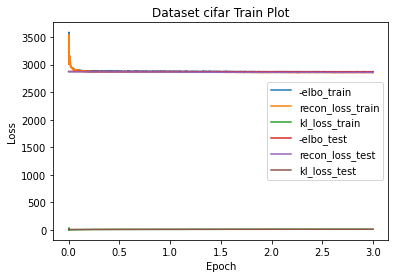

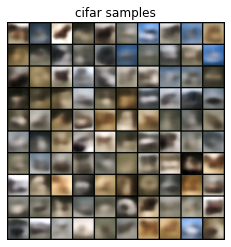

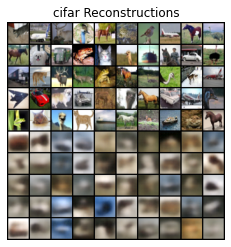

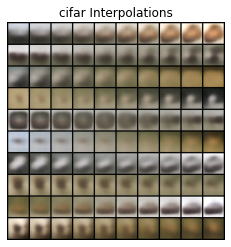

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


100%|██████████| 5/5 [02:22<00:00, 28.45s/it]


Final -ELBO: 2846.5326, Recon Loss: 2839.5196, KL Loss: 7.0130


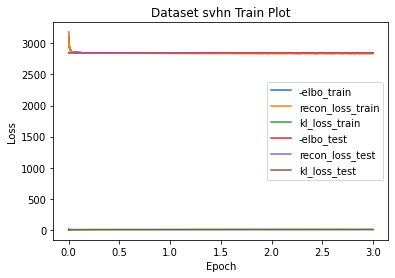

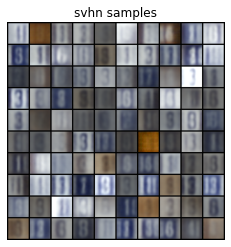

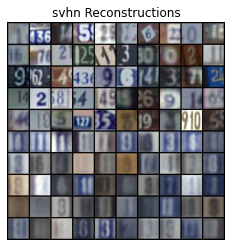

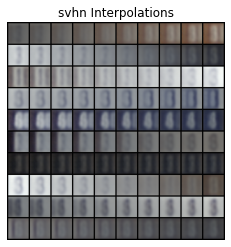

In [20]:
q2_results('cifar', q2_b)
q2_results('svhn', q2_b)

# Summary

In this notebook you implemented simple VAEs, you can also try to implement more complicated models such as VQ-VAE or PixelVAE

This task will wait you in `bonus.ipynb` section